In [1]:
import os
import sys
sys.path.append('../utils')
import datetime
import torch
import torchvision
import numpy as np
import pylab as plt
import albumentations
from visdom import Visdom
from tqdm import tqdm

import segmentation_models_pytorch as smp
from datasets import ACDCDataset
from training import dice_loss, tversky_loss, ce_loss

EXP_NAME = 'unet-densenet161'
LOG_FILE = EXP_NAME + '.log'
VIS_FILE = EXP_NAME + '.vislog'

In [2]:
augmentation = albumentations.Compose([
    albumentations.OneOf([
        albumentations.GridDistortion(p=1.),
        albumentations.ElasticTransform(p=1.),
        albumentations.OpticalDistortion(p=1.),
        albumentations.ShiftScaleRotate(p=1.),
    ], p=.7),
    albumentations.RandomBrightnessContrast(p=.7),
    albumentations.RandomGamma(p=.7),
    albumentations.RandomRotate90(p=.7),
    albumentations.Rotate(p=1.),
    albumentations.VerticalFlip(p=.7),
    albumentations.HorizontalFlip(p=.7),
    albumentations.Transpose(p=.7),
    albumentations.CLAHE(p=1.),
    albumentations.Resize(256, 256),
])

dataset = ACDCDataset('../data/acdc/training', None, augmentation, preload=True)
train_dataset, val_dataset = dataset.split_train_val(train_size=0.7)
train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

In [3]:
len(train_dataset), len(val_dataset)

(1328, 574)

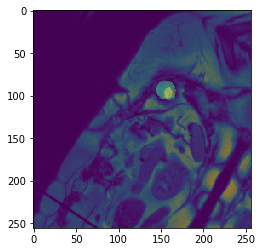

In [4]:
c, img, mask = dataset[79]
plt.imshow(img.numpy()[0])
plt.imshow(mask.numpy()[0], alpha=0.5)
plt.show()

In [5]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
model = smp.Unet('densenet161', encoder_weights=None, in_channels=1, classes=4).to(device)

In [7]:
# optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
optimizer = torch.optim.SGD(model.parameters(), lr=3e-4, momentum=0.9)
criterion = lambda p,t : dice_loss(t, p) * .75 + ce_loss(t.squeeze(1), p, weights=None) * .25
metric = lambda p,t : dice_loss(t, p) * .75 + ce_loss(t.squeeze(1), p, weights=None) * .25

In [8]:
if not os.path.exists(os.path.join('chckpoints', EXP_NAME)):
    os.makedirs(os.path.join('chckpoints', EXP_NAME))

In [9]:
vis = Visdom(log_to_filename=VIS_FILE, offline=True)
train_losses = np.ones(100)
val_losses = np.ones(100)
for epoch in range(100):
    train_loss = 0.
    val_loss = 0.
    model.train()
    for _, images, targets in tqdm(train_generator, total=len(train_generator)):
        images = images.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        # backpropagate
        pred = model(images)
        loss = criterion(pred, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() / len(train_generator)
    torch.cuda.empty_cache()
    model.eval()
    for _, images, targets in tqdm(val_generator, total=len(val_generator)):
        images = images.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            pred = model(images)
        loss = metric(pred, targets)
        val_loss += loss.item() / len(val_generator)
    if epoch % 10 == 0: torch.save(model.state_dict(), os.path.join('chckpoints', EXP_NAME, 'checkpoints_%d.pth' % epoch))
    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss
    vis.line(X=[epoch], Y=[train_loss], win='loss curves', name='train', update='append')
    vis.line(X=[epoch], Y=[val_loss], win='loss curves', name='val', update='append')
    vis.line(X=[epoch], Y=[optimizer.param_groups[0]['lr']], win='loss curves', name='lr', update='append')
    print('epoch: %d train loss: %.3f val loss: %.3f time: %s' % (epoch, train_loss, val_loss, str(datetime.datetime.now())))
    with open(LOG_FILE, 'a') as _f:
        print('epoch: %d train loss: %.3f val loss: %.3f time: %s' % (epoch, train_loss, val_loss, str(datetime.datetime.now())), file=_f)
    if optimizer.param_groups[0]['lr'] < 2e-8:
        train_losses = train_losses[:epoch+1]
        val_losses = val_losses[:epoch+1]
        break

  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 0 train loss: 0.106 val loss: 0.097 time: 2020-05-10 13:12:36.846294


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 1 train loss: 0.109 val loss: 0.099 time: 2020-05-10 13:14:04.695820


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 2 train loss: 0.104 val loss: 0.098 time: 2020-05-10 13:15:30.863864


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 3 train loss: 0.105 val loss: 0.097 time: 2020-05-10 13:16:59.592723


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 4 train loss: 0.103 val loss: 0.092 time: 2020-05-10 13:18:26.614122


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 5 train loss: 0.107 val loss: 0.094 time: 2020-05-10 13:19:55.322219


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 6 train loss: 0.105 val loss: 0.095 time: 2020-05-10 13:21:22.561520


  0%|          | 0/42 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [6]:
# model.load_state_dict(torch.load('chckpoints/unet-densenet121/checkpoints_40.pth'))
model = torch.load('unet-densenet161.pth').to(device)

In [10]:
torch.cuda.empty_cache()

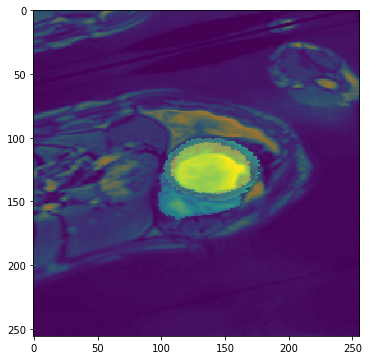

In [20]:
c, img, mask = val_dataset[24]

plt.figure(figsize=(6,6))
plt.imshow(img.numpy()[0])
plt.imshow(mask.numpy()[0], alpha=0.5)
plt.show()

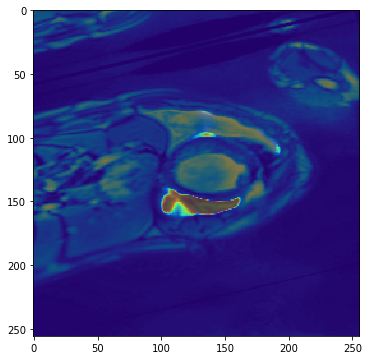

In [21]:
model.eval()
with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))[0]
probas = torch.nn.functional.softmax(pred, dim=0)

plt.figure(figsize=(6,6))
plt.imshow(img.numpy()[0])
plt.imshow(probas.cpu().numpy()[1], alpha=0.5, cmap=plt.cm.jet)
plt.show()

In [22]:
torch.save(model, 'unet-densenet161.pth')